In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_15 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-03 23:29:06.664166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=8, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=8,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=100, save_dir=stage1_dir, patience=20,kl_warmup_epochs=80)

[Epoch 9] KL weight: 0.0001, KL: 0.0660
[Epoch 19] KL weight: 0.0002, KL: 0.1388
[Epoch 29] KL weight: 0.0004, KL: 0.2113
[Epoch 39] KL weight: 0.0005, KL: 0.2836
[Epoch 49] KL weight: 0.0006, KL: 0.3557
[VAE Pretrain] Epoch 50/100 Avg ELBO: -396.0102 (Recon: -396.3659, KLw: 0.3557)
[Epoch 59] KL weight: 0.0007, KL: 0.4276
[Epoch 69] KL weight: 0.0009, KL: 0.4993
[Epoch 79] KL weight: 0.0010, KL: 0.5712
[Epoch 89] KL weight: 0.0010, KL: 0.5780
[Epoch 99] KL weight: 0.0010, KL: 0.5776
[VAE Pretrain] Epoch 100/100 Avg ELBO: -458.5945 (Recon: -459.1721, KLw: 0.5776)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=80,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/80 Avg Loss: 0.0172
[SOM] Phase 1 Epoch 20/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 30/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 40/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 50/80 Avg Loss: 0.0172
[SOM] Phase 3 Epoch 60/80 Avg Loss: 0.0152
[SOM] Phase 3 Epoch 70/80 Avg Loss: 0.0151


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 3126284
[Joint] Calculating  patient_start_offset_global (once before training)...


[Joint]  patient_start_offset_global calculated. Shape: torch.Size([2150])


RuntimeError: The size of tensor a (3104) must match the size of tensor b (24832) at non-singleton dimension 1

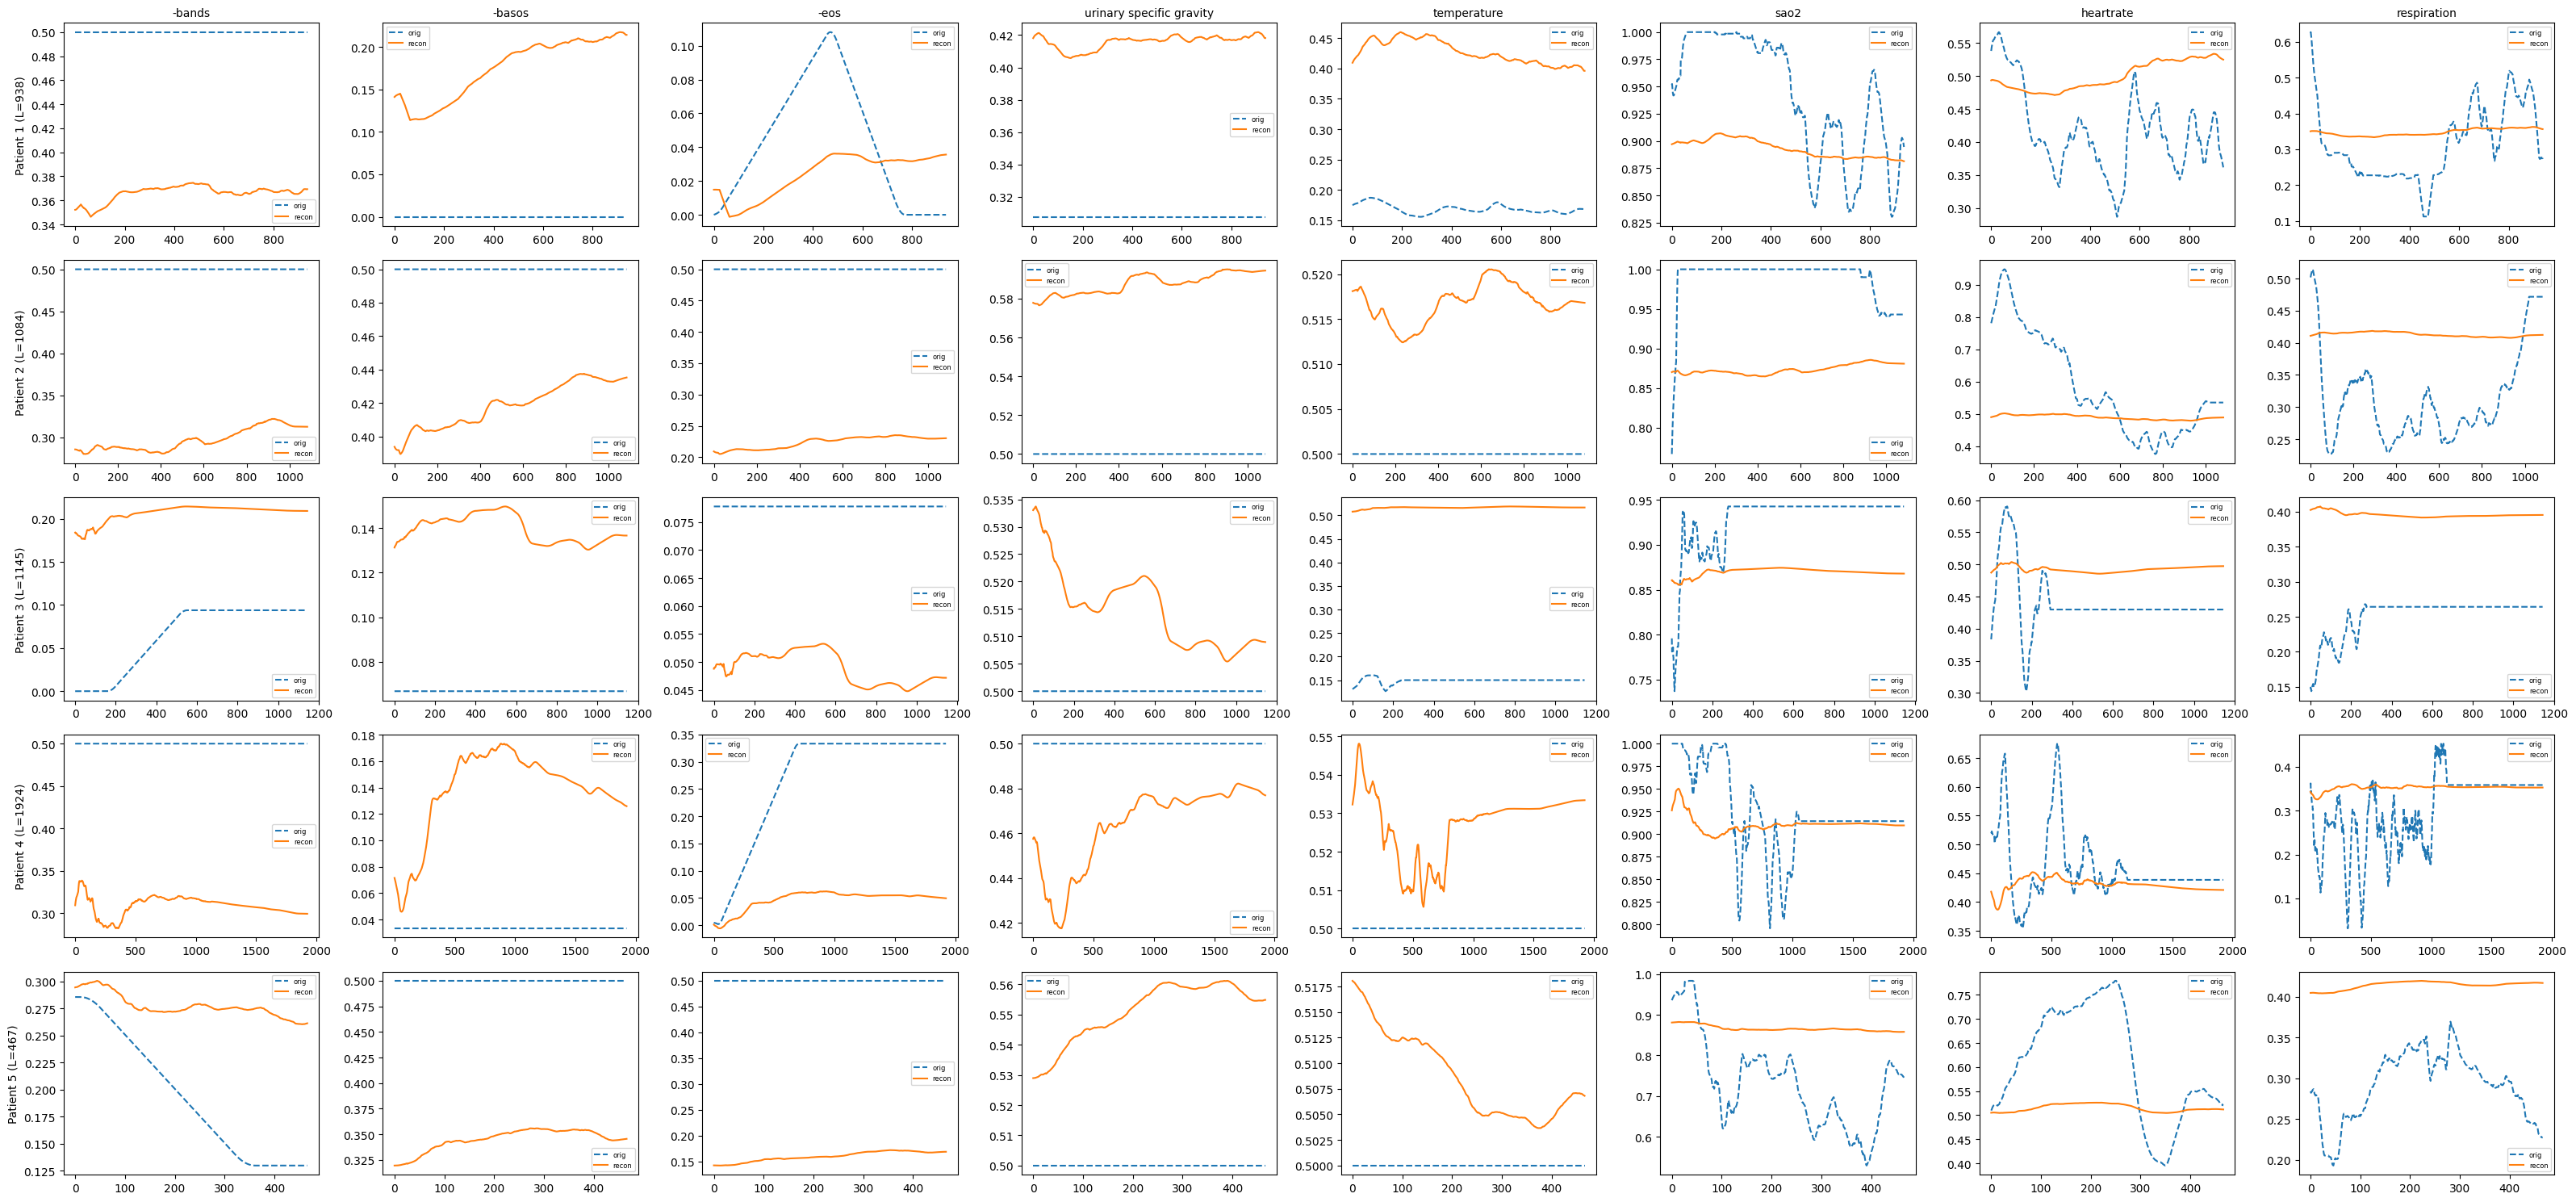

In [ ]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 18250 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.1103
  Std (overall): 1.1683
  Per-dim mean:
tensor([ 1.0853,  0.6772, -0.0505,  0.1777, -1.4677, -0.0907, -1.9618, -0.5519,
         1.5611, -0.0713,  2.9102, -1.1488,  0.6771,  0.1243, -1.4273, -0.5426,
         0.1059, -2.8058, -0.9763, -0.9547,  0.5795, -0.4554, -1.6286,  0.0167,
        -2.5775,  0.1174,  0.5539,  1.0155,  0.1039,  0.4637,  0.5763, -0.8964,
         0.0392,  2.0352, -0.9606, -1.8937,  2.1638, -0.4982,  1.3816, -0.5763,
         0.0987, -0.7941, -0.8443,  0.1065, -0.1845,  0.4329,  0.1201, -0.4064,
        -0.0604,  0.2568, -0.2482, -1.3682, -0.4189,  0.7344, -0.1154, -0.5566,
         0.0351,  1.4232,  1.1811, -0.8947, -1.2458,  0.8475, -0.0486,  0.0600])
  Per-dim std:
tensor([0.2452, 0.4898, 0.4244, 0.4009, 0.3792, 0.7287, 0.4216, 0.3195, 0.5440,
        0.3586, 0.4546, 0.3638, 0.4934, 0.4450, 0.4565, 0.2982, 0.7405, 0.5035,
        0.5068, 0.3400, 

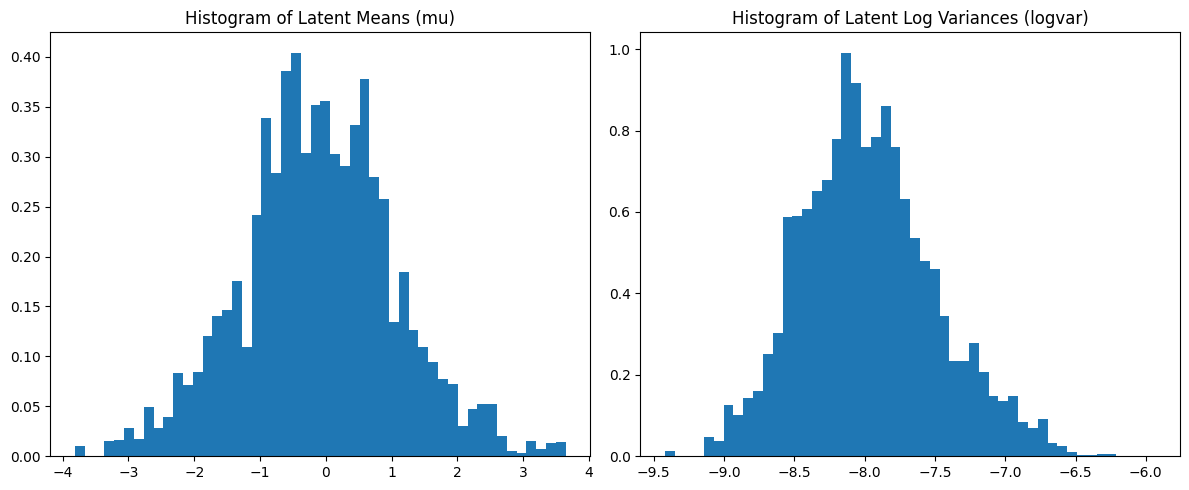

In [6]:
analyze_latent_stats(model1, small_train_loader, device, num_batches_to_analyze=20)

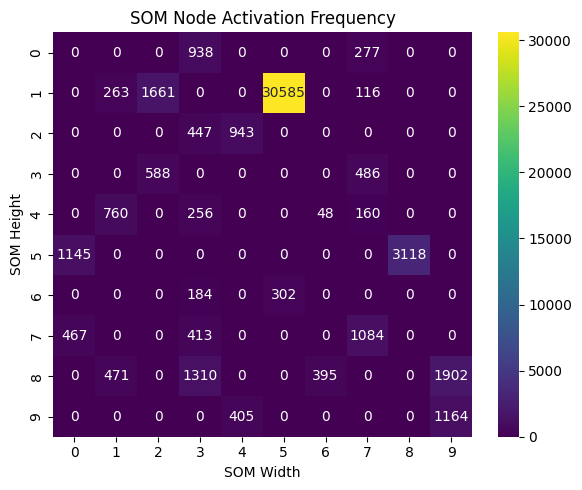

In [11]:
activation_map = compute_som_activation_heatmap(model2, small_train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (18250, 64)
y_all shape: (18250,)


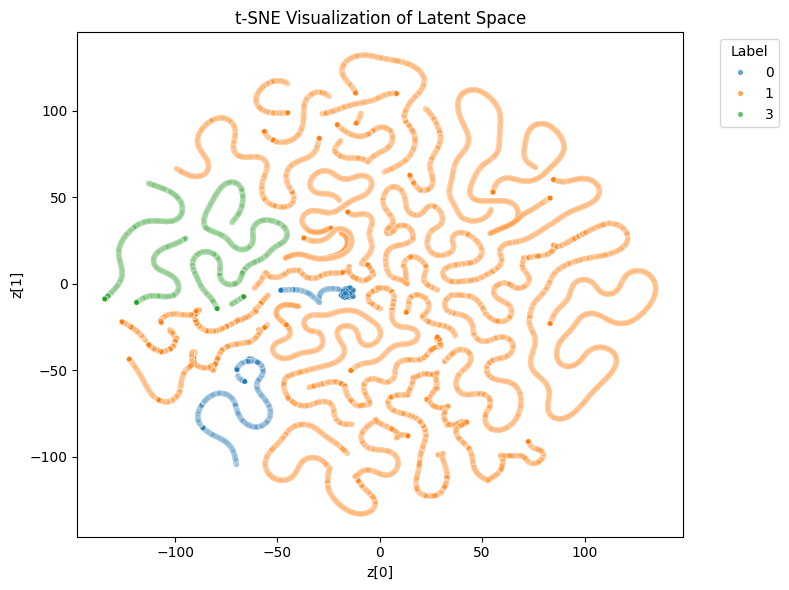

In [24]:
z_all, y_all = collect_latents(model, data_loader=small_train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


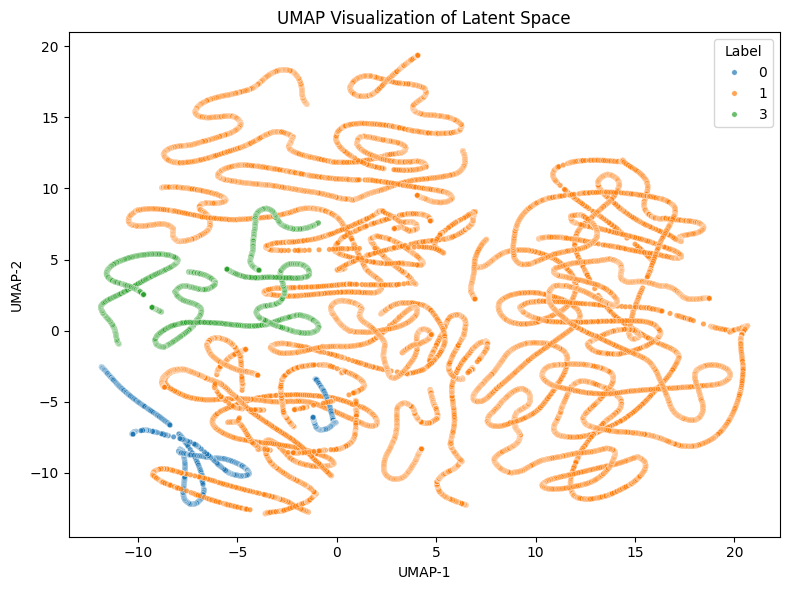

In [26]:
plot_umap(z_all, y_all)
